In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
from datasets import get_dataset
from glove import load_glove_vectors, get_sentence_embedding
from training import train

In [3]:
sample_size = 1000
df = get_dataset("../games_apurado.json", sample_size = sample_size)

df.head()

,name,description,description_cleaned
1770390,Bound by Love,latest release / / / upcoming games / / about ...,latest release upcoming games about the game y...
1608470,Warstride Challenges,"living roadmap about the game race, aim, fire!...",living roadmap about the game race aim fire bl...
1300180,The Cubedex of Brass and Wood,the cubedex of brass and wood is a puzzle game...,the cubedex of brass and wood is a puzzle game...
348490,Beyond Sol,beyond sol is a unique blend of action space c...,beyond sol is a unique blend of action space c...
618360,Aesthetic Melody,the year is 1999 . it is the future .... ａｅｓｔｈ...,the year is 1999 it is the future ａｅｓｔｈｅｔｉｃ ｍｅ...


In [4]:
# !!!! Change this to where glove is located in your computer !!!!
# If you don't have it, check file downloadglove.py
glove_file = "../glove.6B/glove.6B.300d.txt"
glove_vectors = load_glove_vectors(glove_file)

In [5]:
embeddings_list = []
for text in tqdm(df['description_cleaned']):
    embedding = get_sentence_embedding(text, glove_vectors)
    embeddings_list.append(embedding)

embeddings_matrix = torch.stack(embeddings_list)

100%|██████████| 997/997 [00:00<00:00, 1027.83it/s]


In [6]:
num_epochs = 50  # !!!! Configure for how many epochs you want !!!!
autoencoder, embeddings_transformed, losses = train(embeddings_matrix, input_dim = 300, hidden_dim = 100, num_epochs = num_epochs)

100%|██████████| 50/50 [00:00<00:00, 320.51it/s]


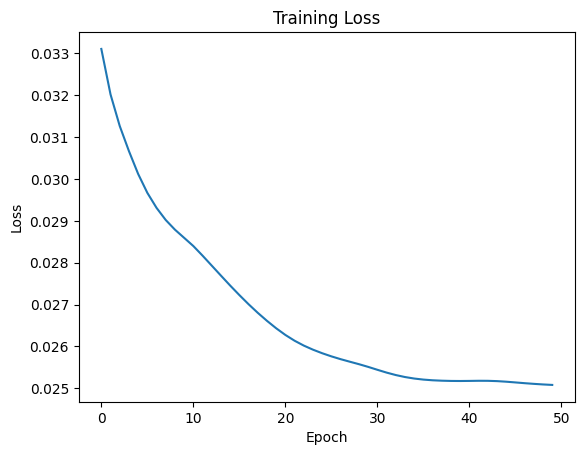

In [7]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [8]:
from sklearn.cluster import KMeans

embeddings_numpy = embeddings_matrix.detach().numpy()
embeddings_transformed_numpy = embeddings_transformed.detach().numpy()

tsne_original = TSNE(n_components=2, random_state=42)
X_tsne_embeddings_original = tsne_original.fit_transform(embeddings_numpy)

tsne_new = TSNE(n_components=2, random_state=42)
X_tsne_embeddings_transformed = tsne_new.fit_transform(embeddings_transformed_numpy)

n_clusters = 8  # !!! Configure for the number of clusters you want / believe to exist !!!
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters_original = kmeans.fit_predict(embeddings_numpy)

In [9]:
df_original = pd.DataFrame({
    'TSNE_1': X_tsne_embeddings_original[:, 0],
    'TSNE_2': X_tsne_embeddings_original[:, 1],
    'Cluster': clusters_original,
    'Name': df['name'],
    'Description': [desc[:100] + '...' for desc in df['description']] 
})

df_transformed = pd.DataFrame({
    'TSNE_1': X_tsne_embeddings_transformed[:, 0],
    'TSNE_2': X_tsne_embeddings_transformed[:, 1],
    'Cluster': clusters_original,
    'Name': df['name'],
    'Description': [desc[:100] + '...' for desc in df['description']]
})

fig_original = px.scatter(
    df_original,
    x='TSNE_1', y='TSNE_2',
    color='Cluster',
    hover_data={'Name': True, 'Description': True, 'Cluster': True},
    title="TSNE of Initial Embeddings"
)
fig_original.update_traces(marker=dict(size=5, opacity=0.7))
fig_original.show()

fig_transformed = px.scatter(
    df_transformed,
    x='TSNE_1', y='TSNE_2',
    color='Cluster',
    hover_data={'Name': True, 'Description': True, 'Cluster': True},
    title="TSNE of Transformed Embeddings"
)
fig_transformed.update_traces(marker=dict(size=5, opacity=0.7))
fig_transformed.show()

In [10]:
input_text = "not bloody"
input_embedding = get_sentence_embedding(input_text, glove_vectors)

input_transformed = autoencoder.encoder(input_embedding.unsqueeze(0))

cosine_similarities = F.cosine_similarity(input_transformed, embeddings_transformed).squeeze()
cosine_similarities = cosine_similarities.detach().cpu().numpy()

# !!!! Configure for however many results you want !!!!
num_search = 10
top_indices = np.argsort(-cosine_similarities)[:num_search]

# Print the results
print(f"Query: {input_text}\nResults:\n")
for i, idx in enumerate(top_indices, start=1):
    if cosine_similarities[idx] < 0.6:
        break
    similarity = cosine_similarities[idx]
    description = df.iloc[idx]['description']
    name = df.iloc[idx]['name']
    print(f"Top {i} - similarity: {similarity:.5f}")
    print(f"Name: {name}")
    print(f"Description: {description}\n")

Query: not bloody
Results:

Top 1 - similarity: 0.95574
Name: 36 Fragments of Midnight
Description: this time midnight's friends lost of their star fragments! your task is to find them, and take them back, but it won't be easy. in this procedurally generated platform game, you have to avoid deadly lasers, circular saws and spikes to collect all the fragments, to get their greatest gift. do you have what it takes to collect all?

Top 2 - similarity: 0.95484
Name: Yujiro's Mansion
Description: you're a robber going around a neighborhood doing what you do best. after robbing many houses you stumble across a huge mansion. you break into the mansion, but what you didn't know was that this mansion belonged to the 'strongest creature in the world.' the pinnacle of physical force, yujiro hanma. can you rob yujiro's mansion and get out alive? this is the first game i've made with a game engine. let me know what you guys think and what bugs i could fix. enjoy! features - singleplayer - survival 